In [1]:
"""
Temporal Graph Neural Network for Anti-Money Laundering Detection
================================================================


"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.data import Data, Batch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tqdm import tqdm
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))  # Adjust as needed
from config import DATAPATH, SAMPLE_DATAPATH

In [3]:
class TemporalGraphDataProcessor:
    """
    Processes SAML-D dataset into temporal graph format
    Using preprocessed features
    """

    def __init__(self, time_window='7D'):  # 7 days default
        self.time_window = time_window
        self.scalers = {}
        self.encoders = {}
    
    def load_and_preprocess(self, df):
        """Load SAML-D dataset and perform initial preprocessing"""

        print("Loading data...")
        # Combine date and time into datetime
        df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
        
        # Sort by datetime for temporal processing
        df = df.sort_values('datetime').reset_index(drop=True)
        
        print(f"Loaded {len(df)} transactions")
        print(f"Suspicious transactions: {df['Is_laundering'].sum()} ({df['Is_laundering'].mean()*100:.3f}%)")
        
        return df
    
    def engineer_features(self, df):
        """Create temporal and graph-specific features"""
        print("Engineering features...")
        
        # Time-based features
        df['hour'] = df['datetime'].dt.hour.astype('int8')
        df['month'] = df['datetime'].dt.month.astype('int8')
        df['day_of_week'] = df['datetime'].dt.dayofweek.astype('int8')
        df['day_of_month'] = df['datetime'].dt.day.astype('int8')
        df['is_weekend'] = (df['day_of_week'] >= 5).astype('int8')

        # Log transform amount to handle skewness
        df['log_amount'] = np.log1p(df['Amount']).astype('float32')
        
        # Cross-border indicator
        df['cross_border'] = (df['Payment_type'] == 'Cross-border').astype('int8')

        # Risky countries
        risky_countries = {'Mexico', 'Turkey', 'Morocco', 'UAE'}  # Example risky countries
        df['high_risk_sender'] = df['Sender_bank_location'].isin(risky_countries).astype('int8')
        df['high_risk_receiver'] = df['Receiver_bank_location'].isin(risky_countries).astype('int8')

        # Currency mismatch
        df['currency_mismatch'] = (df['Payment_currency'] != df['Received_currency']).astype('int8')

        # Converting Is_laundering to int8
        df['Is_laundering'] = df['Is_laundering'].astype('int8')

        # Delete unnecessary columns
        df = df.drop(columns=['Date', 'Time', 'Amount', 'Sender_bank_location', 'Receiver_bank_location', 
                              'Payment_currency', 'Received_currency', 'Laundering_type'])
        
        return df
    
    def create_temporal_snapshots(self, df, account_features):
        """Create temporal graph snapshots"""
        print("Creating temporal graph snapshots...")

        # Get all unique accounts globally
        all_accounts = list(set(df['Sender_account'].unique()) | set(df['Receiver_account'].unique()))
        global_account_to_idx = {acc: idx for idx, acc in enumerate(all_accounts)}
        global_num_nodes = len(all_accounts)
        
        # Define time windows
        start_date = df['datetime'].min().normalize().date()  # Start of first day
        end_date = df['datetime'].max().normalize().date()

        snapshots = []
        print(f"Total time range: {start_date} to {end_date}")

        for window_start in pd.date_range(start=start_date, end=end_date, freq=self.time_window, inclusive='left'):
            window_end = window_start + pd.Timedelta(days=7)
            window_start = pd.to_datetime(window_start).strftime('%Y-%m-%d')
            window_end = pd.to_datetime(window_end).strftime('%Y-%m-%d')
            print(f"Processing window: {window_start} to {window_end}")

            # Get transactions in current window
            window_mask = (df['datetime'] >= window_start) & (df['datetime'] < window_end)
            window_trnx_data = df[window_mask].copy()

            # Account features for this window
            window_accounts_features = account_features[account_features['window_start'] == window_start]
            
            if len(window_trnx_data) > 0:
                # Create graph for this window
                graph_data = self._create_graph_snapshot(window_trnx_data, window_accounts_features,
                                                          window_start, global_account_to_idx, global_num_nodes)
                if graph_data is not None:
                    snapshots.append(graph_data)
        
        print(f"Created {len(snapshots)} temporal snapshots")
        return snapshots, global_num_nodes

    def _create_graph_snapshot(self, window_trnx_data, window_accounts_features, 
                               timestamp, global_account_to_idx, global_num_nodes):
        """Create a single graph snapshot"""
        if len(window_trnx_data) == 0:
            return None
        
        # # Get unique accounts
        # active_accounts = set(window_trnx_data['Sender_account'].tolist() + 
        #                    window_trnx_data['Receiver_account'].tolist())

        # Create edges (transactions)
        edge_feature_columns = [
            'Payment_type_encoded', 'log_amount', 'month', 'day_of_week', 'hour', 
            'currency_mismatch', 'cross_border', 'high_risk_sender', 'high_risk_receiver',
        ]

        # Node feature columns
        node_feature_columns = ['sent_txns_count', 'fan_out',
       'recv_txns_count', 'fan_in', 'max_sent_txn_count', 'max_recv_txn_count',
       'sent_recv_ratio', 'fanout_fanin_ratio', 'log_med_sent_amt',
       'log_std_sent_amt', 'log_med_recv_amt', 'log_std_recv_amt',
       'log_max_sent_txn_amt', 'log_max_recv_txn_amt', 'log_total_txns_amt']

        sender_mapped = window_trnx_data['Sender_account'].map(global_account_to_idx)
        receiver_mapped = window_trnx_data['Receiver_account'].map(global_account_to_idx)
        edge_index = np.column_stack((sender_mapped, receiver_mapped))
        edge_features = window_trnx_data[edge_feature_columns].values
        transaction_labels = window_trnx_data['Is_laundering'].values
        
        # Create node features (account features) - zero for all, update active
        node_features = np.zeros((global_num_nodes, len(node_feature_columns)))
        try:
            window_accounts_features['global_idx'] = window_accounts_features['account'].map(global_account_to_idx)
            node_features[window_accounts_features['global_idx'].values] = window_accounts_features[node_feature_columns].values
        except: 
            raise ValueError("Error in mapping account features to global indices.")
        
        # Convert to tensors
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        node_features = torch.tensor(node_features, dtype=torch.float)
        edge_features = torch.tensor(edge_features, dtype=torch.float)
        transaction_labels = torch.tensor(transaction_labels, dtype=torch.float)
        
        # Create PyTorch Geometric data object
        data = Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_features,
            y=transaction_labels,
            timestamp=timestamp,
            num_nodes=global_num_nodes
        )
        
        return data

In [4]:
# Temporal GNN Model for Edge Classification
class TemporalEdgeClassifier(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super(TemporalEdgeClassifier, self).__init__()
        self.rnn = nn.GRUCell(node_dim, hidden_dim)
        self.gnn1 = GATConv(hidden_dim, hidden_dim)
        self.gnn2 = GATConv(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim * 2 + edge_dim, 1)  # Binary classification

    def forward(self, data, h):
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        
        # Update node hidden states with RNN (using current x)
        h = self.rnn(x, h)
        
        # Apply GNN layers
        h = F.relu(self.gnn1(h, edge_index))
        h = F.relu(self.gnn2(h, edge_index))
        
        # Edge features: concat sender h, receiver h, edge_attr
        h_i = h[edge_index[0]]
        h_j = h[edge_index[1]]
        edge_input = torch.cat([h_i, h_j, edge_attr], dim=-1)
        
        # Prediction
        out = self.lin(edge_input)
        
        return out, h  # Return logits and updated h

In [5]:
def train_model(snapshots, global_num_nodes, epochs=50, device='cuda' if torch.cuda.is_available() else 'cpu'):
    node_dim = 15  # From node features
    edge_dim = 9  # From edge features: 
    hidden_dim = 128
    
    model = TemporalEdgeClassifier(node_dim, edge_dim, hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=5, factor=0.5
        )
    
    # Compute pos_weight for imbalance (~960:1 from ~0.1% positive)
    total_trans = sum(len(s.y) for s in snapshots)
    total_pos = sum(s.y.sum() for s in snapshots)
    pos_weight = torch.tensor([(total_trans - total_pos) / total_pos]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    # Split snapshots chronologically: 70% train, 15% val, 15% test
    n = len(snapshots)
    train_end = int(0.7 * n)
    val_end = int(0.85 * n)
    train_snaps = snapshots[:train_end]
    val_snaps = snapshots[train_end:val_end]
    test_snaps = snapshots[val_end:]
    
    print(f"Training on {len(train_snaps)} snapshots, validating on {len(val_snaps)}, testing on {len(test_snaps)}")

    train_loss_history = []
    val_loss_history = []
    val_preds, val_labels = [], []
    test_preds, test_labels = [], []
    
    # h = torch.zeros(global_num_nodes, hidden_dim).to(device)
    for epoch in range(epochs):
        model.train()
        h = torch.zeros(global_num_nodes, hidden_dim).to(device)  # Initial hidden state
        
        train_loss = 0
        for snap in train_snaps:
            snap = snap.to(device)
            out, h = model(snap, h)
            loss = criterion(out.squeeze(), snap.y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            h = h.detach()  # Detach history
        
        avg_train_loss = train_loss / len(train_snaps)
        train_loss_history.append(avg_train_loss)
        
        # Validation
        model.eval()
        with torch.no_grad():
            h = torch.zeros(global_num_nodes, hidden_dim).to(device)
            val_loss = 0
            for snap in val_snaps:
                snap = snap.to(device)
                out, h = model(snap, h)
                loss = criterion(out.squeeze(), snap.y)
                val_loss += loss.item()
            
            avg_val_loss = val_loss / len(val_snaps)
            val_loss_history.append(avg_val_loss)

            scheduler.step(val_loss)
        
        # Print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"After Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    
    print("Training complete. Generating predictions...")
    # Validation set    
    model.eval()
    with torch.no_grad():
        h = torch.zeros(global_num_nodes, hidden_dim).to(device)
        for snap in val_snaps:
            snap = snap.to(device)
            out, h = model(snap, h)
            preds = torch.sigmoid(out).squeeze().cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(snap.y.cpu().numpy())

    # Test set
    model.eval()
    with torch.no_grad():
        h = torch.zeros(global_num_nodes, hidden_dim).to(device)
        for snap in test_snaps:
            snap = snap.to(device)
            out, h = model(snap, h)
            preds = torch.sigmoid(out).squeeze().cpu().numpy()
            test_preds.extend(preds)
            test_labels.extend(snap.y.cpu().numpy())
    
    return {
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'val_preds': np.array(val_preds),
        'val_labels': np.array(val_labels),
        'test_preds': np.array(test_preds),
        'test_labels': np.array(test_labels)
    }

# Usage Example (assuming data is loaded and processed)
# processor = TemporalGraphDataProcessor()
# df = processor.load_and_preprocess(df)
# df = processor.engineer_features(df)
# snapshots, global_num_nodes = processor.create_temporal_snapshots(df)
# results = train_model(snapshots, global_num_nodes)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Load the entire dataset
df = pd.read_csv(DATAPATH)

# Filter by data range
# df = df[df['Date'] < '2023-08-18']
# df = df.head(300000).copy()

# run feature engg.ipynb to get the account_stats_7D.csv
account_stats = pd.read_csv('../account_stats_7D.csv')

In [8]:
graph_processor = TemporalGraphDataProcessor()
df = graph_processor.load_and_preprocess(df)
df = graph_processor.engineer_features(df)

Loading data...
Loaded 9504852 transactions
Suspicious transactions: 9873 (0.104%)
Engineering features...


In [9]:
from sklearn.preprocessing import LabelEncoder

# For each categorical column
# categorical_cols = ['Payment_currency', 'Received_currency', 'Sender_bank_location', 
#                    'Receiver_bank_location', 'Payment_type']
categorical_cols = ['Payment_type']

for col in categorical_cols:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
# Drop original object columns
df = df.drop(categorical_cols, axis=1)

In [10]:
# Process accont_stats
columns = ['med_sent_amt', 'std_sent_amt', 'med_recv_amt', 'std_recv_amt', 
           'max_sent_txn_amt', 'max_recv_txn_amt', 'total_txns_amt']

for col in columns:
    account_stats['log_' + col] = np.log1p(account_stats[col]).astype('float32')

account_stats = account_stats.drop(columns, axis=1)

In [11]:
# Set data types to optimize memory
account_stats = account_stats.astype({
    'sent_txns_count': 'int32',
    'recv_txns_count': 'int32',
    'fan_out': 'int32',
    'fan_in': 'int32',
    'max_sent_txn_count': 'int32',
    'max_recv_txn_count': 'int32',
    'sent_recv_ratio': 'float32',
    'fanout_fanin_ratio': 'float32'
})

In [12]:
processor = TemporalGraphDataProcessor()
snapshots, global_num_nodes = processor.create_temporal_snapshots(df, account_stats)

Creating temporal graph snapshots...
Total time range: 2022-10-07 to 2023-08-23
Processing window: 2022-10-07 to 2022-10-14
Processing window: 2022-10-14 to 2022-10-21
Processing window: 2022-10-21 to 2022-10-28
Processing window: 2022-10-28 to 2022-11-04
Processing window: 2022-11-04 to 2022-11-11
Processing window: 2022-11-11 to 2022-11-18
Processing window: 2022-11-18 to 2022-11-25
Processing window: 2022-11-25 to 2022-12-02
Processing window: 2022-12-02 to 2022-12-09
Processing window: 2022-12-09 to 2022-12-16
Processing window: 2022-12-16 to 2022-12-23
Processing window: 2022-12-23 to 2022-12-30
Processing window: 2022-12-30 to 2023-01-06
Processing window: 2023-01-06 to 2023-01-13
Processing window: 2023-01-13 to 2023-01-20
Processing window: 2023-01-20 to 2023-01-27
Processing window: 2023-01-27 to 2023-02-03
Processing window: 2023-02-03 to 2023-02-10
Processing window: 2023-02-10 to 2023-02-17
Processing window: 2023-02-17 to 2023-02-24
Processing window: 2023-02-24 to 2023-03

In [13]:
results = train_model(snapshots, global_num_nodes, epochs=100)

Training on 32 snapshots, validating on 7, testing on 7
After Epoch 10: Train Loss: 0.4571, Validation Loss: 0.5316
After Epoch 20: Train Loss: 0.3263, Validation Loss: 0.3515
After Epoch 30: Train Loss: 0.2226, Validation Loss: 0.3158
After Epoch 40: Train Loss: 0.2027, Validation Loss: 0.3199
After Epoch 50: Train Loss: 0.1840, Validation Loss: 0.3019
After Epoch 60: Train Loss: 0.1904, Validation Loss: 0.3019
After Epoch 70: Train Loss: 0.1547, Validation Loss: 0.2871
After Epoch 80: Train Loss: 0.1423, Validation Loss: 0.2915
After Epoch 90: Train Loss: 0.1391, Validation Loss: 0.2938
After Epoch 100: Train Loss: 0.1382, Validation Loss: 0.2944
Training complete. Generating predictions...


In [14]:
from sklearn.metrics import confusion_matrix


# Function to compute and print confusion matrix
def compute_confusion_matrix(labels, preds, threshold=0.5):

    # Convert probabilities to binary predictions using the threshold
    binary_preds = (preds >= threshold).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(labels, binary_preds)
    
    print("Confusion Matrix:")
    print(cm)
    
    # Optional: Extract and print TP, TN, FP, FN
    tn, fp, fn, tp = cm.ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    print(f"Precision: {tp / (tp + fp + 1e-8):.4f}")
    print(f"Recall: {tp / (tp + fn + 1e-8):.4f}")

In [15]:
test_preds = results['test_preds']
test_labels = results['test_labels']
val_preds = results['val_preds']
val_labels = results['val_labels']

In [16]:
compute_confusion_matrix(val_labels, val_preds, threshold=0.95)

Confusion Matrix:
[[1450515    6847]
 [    348    1110]]
True Negatives (TN): 1450515
False Positives (FP): 6847
False Negatives (FN): 348
True Positives (TP): 1110
Precision: 0.1395
Recall: 0.7613


In [17]:
compute_confusion_matrix(test_labels, test_preds, threshold=0.95)

Confusion Matrix:
[[1375513    7655]
 [    359    1282]]
True Negatives (TN): 1375513
False Positives (FP): 7655
False Negatives (FN): 359
True Positives (TP): 1282
Precision: 0.1434
Recall: 0.7812


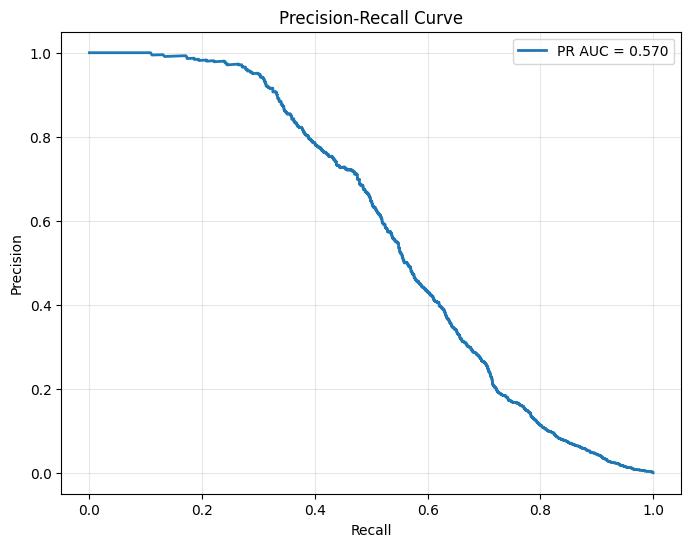

PR AUC Score: 0.5699


In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Generate PR curve data
precision, recall, thresholds = precision_recall_curve(test_labels, test_preds)
pr_auc = average_precision_score(test_labels, test_preds)

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"PR AUC Score: {pr_auc:.4f}")